**Predicting Chronic Kidney Disease based on health records**

**Load Modules and helper functions**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [2]:
%matplotlib inline

def auc_scorer(clf, X, y, model): # Helper function to plot the ROC curve
    if model=='RF':
        fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    elif model=='SVM':
        fpr, tpr, _ = roc_curve(y, clf.decision_function(X))
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr,roc_auc

**Load files**

In [16]:
data = pd.read_csv("/content/chronickidneydisease.csv")

In [17]:
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [18]:
data['wc']

0      7800
1      6000
2      7500
3      6700
4      7300
       ... 
395    6700
396    7800
397    6600
398    7200
399    6800
Name: wc, Length: 400, dtype: object

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [20]:
data.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


In [21]:
data[data.duplicated()]

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification


**Cleaning and preprocessing of data for training a classifier**

In [22]:
# Map text to 1/0 and do some cleaning
data[['htn','dm','cad','pe','ane']] = data[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
data[['rbc','pc']] = data[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
data[['pcc','ba']] = data[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
data[['appet']] = data[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
data['classification'] = data['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})
data.rename(columns={'classification':'class'},inplace=True)

In [23]:
# Further cleaning
data['pe'] = data['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
data['appet'] = data['appet'].replace(to_replace='no',value=0)
data['cad'] = data['cad'].replace(to_replace='\tno',value=0)
data['dm'] = data['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
data.drop('id',axis=1,inplace=True)

In [24]:
data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,...,44,7800,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,...,38,6000,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31,7500,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35,7300,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0


**Check the portion of rows with NaN**

1.Now the data is cleaned with improper values labelled NaN. Let's see how many NaNs are there.

2.Drop all the rows with NaN values, and build a model out of this dataset (i.e. df2)

In [25]:
data2 = data.dropna(axis=0)
data2['class'].value_counts()

0.0    115
1.0     43
Name: class, dtype: int64


**Examine correlations between different features**

1.   List item
2.   List item



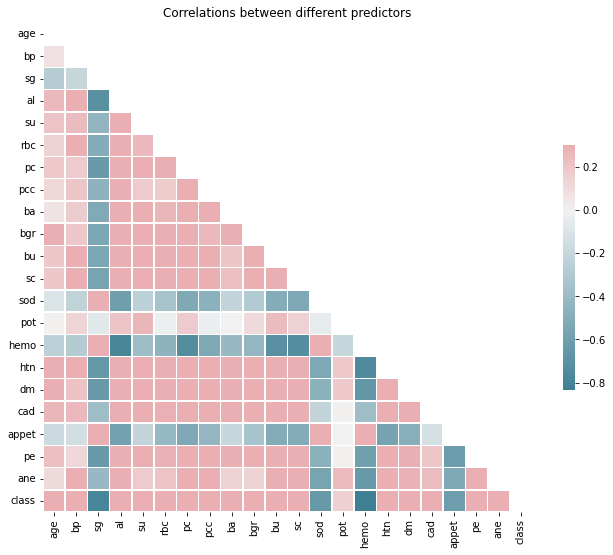

In [26]:
corr_data = data2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_data, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()

**Split the set for training models further into a (sub-)training set and testing set.**

1.   List item
2.   List item



In [27]:
X_train, X_test, y_train, y_test = train_test_split(data2.iloc[:,:-1], data2['class'], 
                                                    test_size = 0.33, random_state=44,
                                                   stratify= data2['class'] )

In [ ]:
X_train.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
317,58.0,70.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,102.0,...,15.0,40,8100,4.9,0.0,0.0,0.0,1.0,0.0,0.0
296,41.0,70.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,125.0,...,16.8,41,6300,5.9,0.0,0.0,0.0,1.0,0.0,0.0
157,62.0,70.0,1.025,3.0,0.0,0.0,1.0,0.0,0.0,122.0,...,12.6,39,7900,3.9,1.0,1.0,0.0,1.0,0.0,0.0
258,42.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,98.0,...,13.9,44,8400,5.5,0.0,0.0,0.0,1.0,0.0,0.0
291,47.0,80.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,124.0,...,14.9,41,7000,5.7,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
print(X_train.shape)
print(X_test.shape)

(105, 24)
(53, 24)


In [29]:
y_train.value_counts()

0.0    76
1.0    29
Name: class, dtype: int64